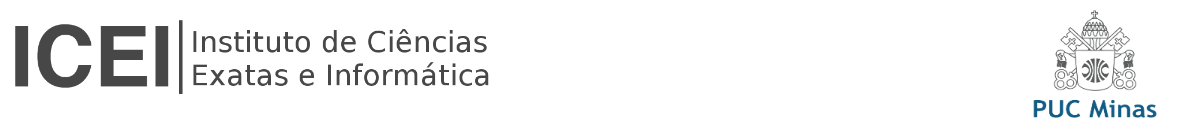

---

# Introdução ao Tensorflow - Parte 4

---

#### Professor: Felipe Reis

#### Data: 2023-05-20

---
### Importação de bibliotecas 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import random
import time

#import plot_images
from plot_helper import plot_helper as plotter

#tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras

---
## Base de Dados MNIST

O banco de dados MNIST contém dígitos manuscritos (escritos a mão).

Tem um conjunto de treinamento com 60.000 imagens e um conjunto de teste com 10.000 imagens. 

Os dígitos foram normalizados por tamanho e centralizados em uma imagem de tamanho fixo.

A base de dados foi criada por Yann LeCun em 1998.

A base MNIST está disponível em: [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/)

![MNist](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Fonte: *Yann LeCun, Corinna Cortes, Christopher J.C. Burges. **Gradient-based learning applied to document recognition**. 1998. Proceedings of the IEEE, 86(11):2278-2324. Disponível em: http://yann.lecun.com/exdb/mnist/. Acesso em: 11 de outubro de 2021.*

In [2]:
#download da base de dados
mnist = keras.datasets.mnist

#divisão em base de treinamento e testes (subdividido em imagens e labels)
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
#impressão da quantidade de imagens da base
print('Conjunto treino: {} amostras'.format(len(train_images)))
print('Conjunto teste: {} amostras'.format(len(test_images)))

Conjunto treino: 60000 amostras
Conjunto teste: 10000 amostras


In [4]:
#definicao dos nomes das classes
#definição das classes 
class_names = ['Dígito 0', 'Dígito 1', 'Dígito 2', 'Dígito 3', 'Dígito 4', 
               'Dígito 5', 'Dígito 6', 'Dígito 7', 'Dígito 8', 'Dígito 9']

### Análise dos Dados

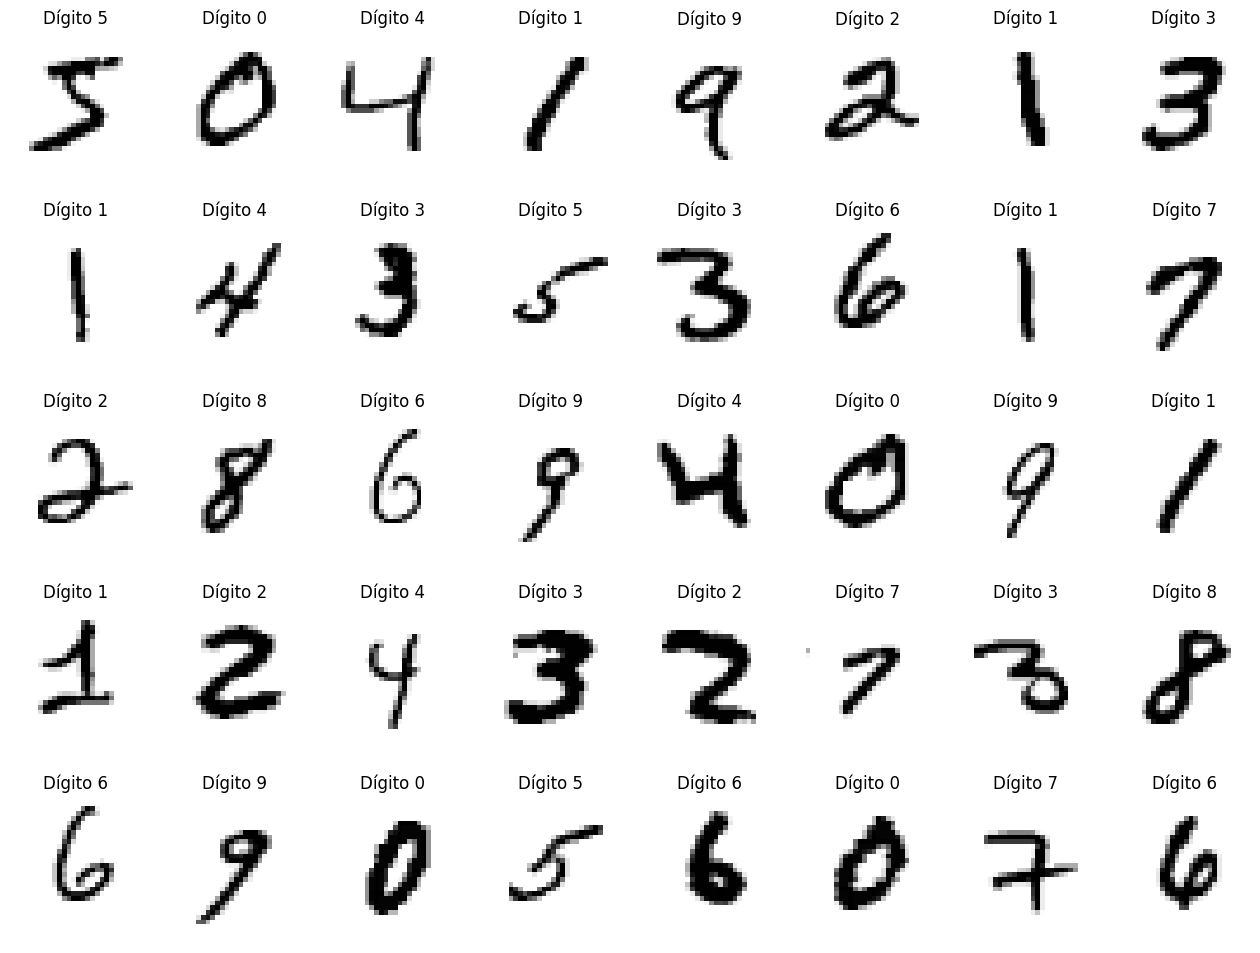

In [5]:
plotter.plot_images(train_images, train_labels, class_names, binary=True, random=False)

---
## Pré processamento

Podemos classificar o conjunto de dados utilizando os mesmos modelos utilizados no Notebook 1.

In [6]:
#pré processamento
train_images = train_images / 255.0
test_images = test_images / 255.0

---
## Treinamento do Modelo

Os modelos des redes neurais abaixo foram baseado nas arquiteturas existentes no Notebook 1.

Para adequação ao conjunto CIFAR-10, a entrada foi alterada para suportar imagens de tamanho 32 $\times$ 32 pixels, com 3 canais de cores.

In [7]:
def load_model_1():
    #modelo de rede sequencial
    return keras.Sequential([
        #transforma a image em um array de imagens de três dimensões (32 x 32 x 3)
        keras.layers.Flatten(input_shape=(28, 28), name='flatten_1'), 

        #Camada de dados totalmente conectadas, com ativação relu
        #A camada possui 128 nós (neurônios)
        keras.layers.Dense(128, activation='relu', name='dense_1'),

        #Camada de dados totalmente conectadas, com ativação softmax
        #A camada possui 10 nós (neurônios), correspondentes às probabilidades de cada classe (10 classes)
        keras.layers.Dense(10, activation='softmax', name='output')
    ])

Epoch 1/10
1875/1875 [==============================] - 11s 3ms/step - loss: 0.2553 - accuracy: 0.9267
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1099 - accuracy: 0.9681
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0764 - accuracy: 0.9766
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0568 - accuracy: 0.9825
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0448 - accuracy: 0.9856
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0352 - accuracy: 0.9886
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0277 - accuracy: 0.9913
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0240 - accuracy: 0.9923
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0174 - accuracy: 0.9945
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.01

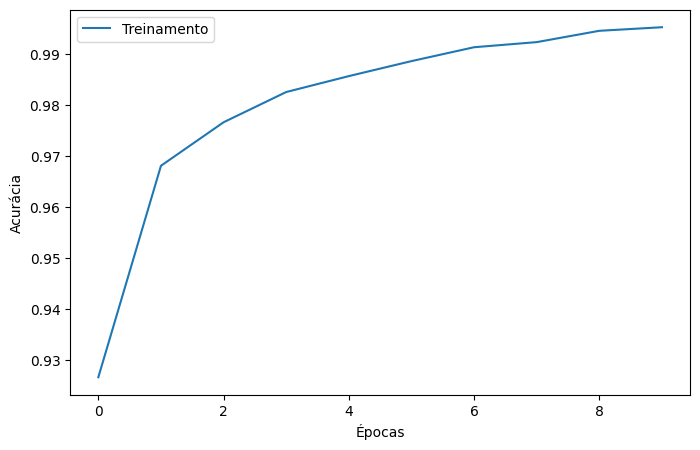

In [8]:
#gera modelo
model1 = load_model_1() #o modelo foi recarregado para melhor comparação dos otimizadores

#define o otimizador
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

#compila o modelo
model1.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#treina o modelo
history = model1.fit(train_images, train_labels, epochs=10)

# plota o gráfico
plotter.plot_history_training(history, metrics=['accuracy'], legend=['Treinamento'], ylabel='Acurácia')

---
### Armazenamento e Recuperação de Pesos

Suponha que uma rede neural foi treinada durante um período de tempo. Após esse período, a rede será utilizada em uma aplicação. 

Neste cenário, é necessário o armazenamento de pesos da rede, de modo a evitar que sejam realizados novos treinamentos.

O armazenamento de pesos também pode ser usado em caso de interrupção do treinamento, permitindo que a rede não precise ser treinada desde o início novamente.

Esta seção contém os códigos necessários para armazenamento e recuperação de pesos.

#### Criação de Checkpoints

Para armazenar os pesos da rede, podemos criar checkpoints, que serão utilizados para salvar pesos com uma determinada frequência.

O código abaixo contém um checkpoint para uma rede neural.

In [9]:
#define diretório onde o arquivo será salvo
checkpoint_path = 'models/model.hdf5'

#cria o checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

Após a criação do checkpoints, podemos adicioná-lo ao treinamento, dentro do método `model.fit`.

O parâmetro `callback` recebe uma método, que é invocado após o fim de uma época. É possível passar uma lista de callbacks para o treinamento da rede.

In [10]:
#treina o modelo
history = model1.fit(train_images, train_labels, epochs=10, callbacks=[checkpoint])

Epoch 1/10
1859/1875 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9961
Epoch 1: saving model to models/model.hdf5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0131 - accuracy: 0.9960
Epoch 2/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9960
Epoch 2: saving model to models/model.hdf5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0123 - accuracy: 0.9960
Epoch 3/10
1860/1875 [============================>.] - ETA: 0s - loss: 0.0097 - accuracy: 0.9969
Epoch 3: saving model to models/model.hdf5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0097 - accuracy: 0.9969
Epoch 4/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9972
Epoch 4: saving model to models/model.hdf5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0091 - accuracy: 0.9972
Epoch 5/10
1862/1875 [============================>.] - ETA: 0s - loss: 

Podemos alterar o checkpoint para salvar a execução somente se a rede melhorar seu desempenho em uma determinada métrica.

In [11]:
#define diretório onde o arquivo será salvo
checkpoint_path = 'models/model.hdf5'

#cria o checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='accuracy', 
                                                save_weights_only=True, save_best_only=True, verbose=1)

In [12]:
#treina o modelo
history = model1.fit(train_images, train_labels, epochs=10, callbacks=[checkpoint])

Epoch 1/10
1860/1875 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9989
Epoch 1: accuracy improved from -inf to 0.99890, saving model to models/model.hdf5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0039 - accuracy: 0.9989
Epoch 2/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9979
Epoch 2: accuracy did not improve from 0.99890
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0067 - accuracy: 0.9979
Epoch 3/10
1858/1875 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.9984
Epoch 3: accuracy did not improve from 0.99890
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0050 - accuracy: 0.9984
Epoch 4/10
1866/1875 [============================>.] - ETA: 0s - loss: 0.0051 - accuracy: 0.9983
Epoch 4: accuracy did not improve from 0.99890
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0051 - accuracy: 0.9984
Epoch 5/10
1865/1875

---
### Recuperação de Pesos

Podemos recuperar os pesos antes do início do treinamento da rede. Para isso, devemos criar o modelo e em seguida carregar os pesos com auxílio do método `load_weights`.

In [13]:
#define diretório onde o arquivo será salvo
checkpoint_path = 'models/model.hdf5'

#gera modelo
model1 = load_model_1() #o modelo foi recarregado para melhor comparação dos otimizadores

#carrega os pesos
model1.load_weights(checkpoint_path)

Após carregar os pesos, podemos executar o treinamento da rede.

In [14]:
#define o otimizador
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

#compila o modelo
model1.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#treina o modelo
history = model1.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0047 - accuracy: 0.9983
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0029 - accuracy: 0.9991
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0050 - accuracy: 0.9984
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0052 - accuracy: 0.9981
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0027 - accuracy: 0.9992
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0045 - accuracy: 0.9985
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0043 - accuracy: 0.9987
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0014 - accuracy: 0.9997
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0060 - accuracy: 0.9983
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.003

---
## Transfer Learning

*Transfer Learning* ou Transferência de Aprendizado corresponde à tarefa de aproveitar o conhecimento obtido em uma tarefa e aplicá-lo à outra.

Em redes neurais, esse conceito é associado à tarefa de reaproveitamento de pesos em tarefas diferentes.

#### *Transfer Learning* MNIST para Fashion MNIST

Suponha que uma rede foi treinada na base de dados MNIST. Após o treinamento, deseja-se que a rede seja utilizada na base Fashion MNIST.

As bases de dados são distintas, porém o conhecimento obtido pela rede na base MNIST pode ser utilizado para auxiliar no treinamento da base Fashion MNIST. Devido a características da rede, algumas *features*, principalmente das camadas iniciais da rede podem ser semelhantes. 

Aproveitar os pesos de uma rede em outra pode diminuir o número de épocas necessárias para treinamento. No entanto, para alguns modelos, o uso de pesos diferentes pode não causar nenhuma melhoria ou, até mesmo, piorar o desempenho da rede neural.

In [15]:
#download da base de dados
fashion_mnist = keras.datasets.fashion_mnist

#divisão em base de treinamento e testes (subdividido em imagens e labels)
(fash_tr_images, fash_tr_labels), (fash_te_images, fash_te_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [16]:
#pré processamento
fash_tr_images = fash_tr_images / 255.0
fash_te_images = fash_te_images / 255.0

#### Treinamento da rede com Transfer Learning

In [17]:
#define diretório onde o arquivo será salvo
checkpoint_path = 'models/model.hdf5'

#gera modelo
model1 = load_model_1() #o modelo foi recarregado para melhor comparação dos otimizadores

#carrega os pesos da rede MNIST
model1.load_weights(checkpoint_path)

#define o otimizador
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

#compila o modelo
model1.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#treina o modelo
history = model1.fit(fash_tr_images, fash_tr_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.1378 - accuracy: 0.7508
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4416 - accuracy: 0.8437
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3806 - accuracy: 0.8622
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3476 - accuracy: 0.8737
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3235 - accuracy: 0.8819
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3061 - accuracy: 0.8877
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2926 - accuracy: 0.8926
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2823 - accuracy: 0.8962
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2732 - accuracy: 0.8990
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.262

---
### Transfer Learning entre Redes Diferentes

Podemos utilizar os pesos de uma rede em uma arquitetura de rede diferente (desde que semelhante).

Como indicado no exemplo anterior, esta tarefa também tem como objetivo diminuir o tempo de treinamento de uma rede neural.

### Base de Dados MNIST

Na tarefa atual, carregaremos um novo modelo de dados, contendo mais nós, semelhante ao recomendado no Notebook 1.

In [18]:
def load_model_2():
    #modelo de rede sequencial
    return keras.Sequential([
        #transforma a image em um array de imagens de três dimensões (32 x 32 x 3)
        keras.layers.Flatten(input_shape=(28, 28), name='flatten_1'), 

        #Camada de dados totalmente conectadas, com ativação relu
        #A camada possui 128 nós (neurônios)
        keras.layers.Dense(128, activation='relu', name='dense_1'),
        keras.layers.Dense(128,  activation='relu', name='dense_2'),
        keras.layers.Dense(128,  activation='relu', name='dense_3'),

        #Camada de dados totalmente conectadas, com ativação softmax
        #A camada possui 10 nós (neurônios), correspondentes às probabilidades de cada classe (10 classes)
        keras.layers.Dense(10, activation='softmax', name='output')
    ])

Utilizaremos os pesos da rede 1.

É importante salientar que essa operação somente é valida caso as redes neurais sejam compatíveis. 

Em caso de arquiteturas de rede muito distintas, tal processo não irá funcionar adequadamente.

In [19]:
#define diretório onde o arquivo será salvo
checkpoint_path = 'models/model.hdf5'

#gera modelo
model2 = load_model_2() #o modelo foi recarregado para melhor comparação dos otimizadores

#carrega os pesos da rede MNIST
model2.load_weights(checkpoint_path, by_name=True)

#define o otimizador
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

#compila o modelo
model2.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#treina o modelo
history = model2.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1052 - accuracy: 0.9704
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0283 - accuracy: 0.9907
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0235 - accuracy: 0.9926
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0224 - accuracy: 0.9931
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0177 - accuracy: 0.9945
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0168 - accuracy: 0.9952
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0152 - accuracy: 0.9958
Epoch 8/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0140 - accuracy: 0.9960
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0123 - accuracy: 0.9962
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.012

#### Treinamento somente de algumas camadas da rede

Se fazemos o *transfer learning* para uma mesma arquitetura de rede neural, pode não ser necessário o treinamento de todas as camadas da rede. 

Em redes diferentes, podemos apenas treinar as novas camadas. Esse procedimento reduz o tempo de treinamento, uma vez que os pesos dessas camadas estarão congelados. Caso queira, os pesos podem ser descongelados em um segundo momento, para refinamento de valores.

O parâmetro que indica que uma camada deve ser treinada é o `trainable`. Por padrão, esse parâmetro é verdadeiro.

In [20]:
def load_model_3():
    #modelo de rede sequencial
    return keras.Sequential([
        #transforma a image em um array de imagens de três dimensões (32 x 32 x 3)
        keras.layers.Flatten(input_shape=(28, 28), name='flatten_1', trainable=False), 

        #Camada de dados totalmente conectadas, com ativação relu
        #A camada possui 128 nós (neurônios)
        keras.layers.Dense(128, activation='relu', name='dense_1', trainable=False),
        keras.layers.Dense(128,  activation='relu', name='dense_2'),
        keras.layers.Dense(128,  activation='relu', name='dense_3'),

        #Camada de dados totalmente conectadas, com ativação softmax
        #A camada possui 10 nós (neurônios), correspondentes às probabilidades de cada classe (10 classes)
        keras.layers.Dense(10, activation='softmax', name='output')
    ])

In [21]:
#define diretório onde o arquivo será salvo
checkpoint_path = 'models/model.hdf5'

#gera modelo
model3 = load_model_3() #o modelo foi recarregado para melhor comparação dos otimizadores

#carrega os pesos da rede MNIST
model3.load_weights(checkpoint_path, by_name=True)

#define o otimizador
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

#compila o modelo
model3.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#treina o modelo
history = model3.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1006 - accuracy: 0.9715
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0267 - accuracy: 0.9918
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0176 - accuracy: 0.9951
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0165 - accuracy: 0.9953
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0108 - accuracy: 0.9968
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0105 - accuracy: 0.9973
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0068 - accuracy: 0.9982
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0097 - accuracy: 0.9977
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0067 - accuracy: 0.9983
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.006

----
----

## Tarefas 

### Tarefa 1 (40 minutos)

Treine um conjunto de dados no modelo CIFAR-10 e salve os pesos. 

Faça o carregamento dos pesos para treinamento do conjunto CIFAR-100. Será necessário alterar a última camada da rede, devido ao número de classes na saída.

#### Atividades Sugeridas

- Utilize uma arquitetura de rede simples com mais de 3 camadas;
- Congele camadas ao treinar a rede CIFAR-100;
- Compare o treinamento da rede congelada com uma rede sem congelamento.
- Verifique se após descongelar os pesos, o desempenho do treinamento da rede melhora.

In [22]:
#insira seu modelo aqui (arquitetura de rede)

In [23]:
#compile seu modelo aqui

In [24]:
#treine seu modelo aqui

In [25]:
#imprima o gráfico de treinamento aqui

In [26]:
#avalie seu modelo aqui